# Bank churn rate analysis

## Introduction

### Problem

Bank is having a high churn rate. The bank wants to understand the churn rate and the factors that influence it.

### Goal

Explore segments with high churn rate and recommend actions to reduce churn.

**Dashboard:** [Tableau Public](https://public.tableau.com/app/profile/roman.gubaidullin/viz/BankChurnDashboard_16953048517320/Main)

### Data

`churn.csv` contains data on clients of a bank. The data includes fields:
 - `User ID` - unique identifier of a client
 - `score` is a credit score of a client
 - `city`
 - `gender`
 - `age`
 - `equity` - number representing total score of equities a client possesses
 - `balance` is a total balance on the client's accounts
 - `products` is a number of products that a client uses
 - `credit_card` is a binary feature that shows if a client uses a credit card
 - `last_activity` is a binary feature that shows if a client is active
 - `estimated_salary` is an estimated salary of a client
 - `churn` is a binary feature that shows if a client has left the bank

### Table of contents

- [Data preparation](#data-preparation)
- [Exploratory data analysis](#exploratory-data-analysis)
- [Segmentation](#segmentation)
- [Hypothesis testing](#hypothesis-testing)
- [Conclusion](#conclusion)
- [Recommendations](#recommendations)

### Libraries used
`Pandas`, `NumPy`, `Matplotlib`, `Seaborn`, `SciPy`


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('churn.csv')

data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Rybinsk,fem,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Rybinsk,fem,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Rybinsk,fem,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Yaroslavl,fem,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Yaroslavl,male,34.0,5,174.00,1,1,0,67353.16,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Data types seem correct. There are some missing values in `age` and `balance` columns. We will explore them later.

## Data preparation <a class="anchor" id="data-preparation"></a>

### Columns renaming

In [4]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'userid':'user_id'})

data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [5]:
data.describe().style.format("{:.2f}")

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,10000.00,10000.00,9974.00,10000.00,7705.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,171814.71,848.70,42.73,2.63,827794.31,1.87,0.68,0.52,147866.89,0.18
std,33708.24,65.45,12.18,1.98,1980614.15,0.79,0.47,0.50,139388.51,0.39
min,94561.00,642.00,18.00,0.00,0.00,0.00,0.00,0.00,2546.30,0.00
25%,142810.25,802.00,33.00,0.00,295554.16,1.00,0.00,0.00,75251.90,0.00
50%,172728.00,853.00,40.00,3.00,524272.20,2.00,1.00,1.00,119658.10,0.00
75%,201261.75,900.00,51.00,4.00,980705.85,2.00,1.00,1.00,174500.54,0.00
max,229145.00,1000.00,86.00,9.00,119113552.01,5.00,1.00,1.00,1395064.45,1.00


Overall **churn** rate is ~18%. We will use this value as a baseline for our analysis.

### Null values handling

In [6]:
# count the number of missing values in each column
data.isnull().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [7]:
data[data['products'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Rybinsk,fem,79.0,3,NaN,0,0,0,25063.96,1


In [8]:
data = data.drop(data[data['products'] == 0].index)

### Duplicates handling

In [9]:
# check duplicates in the data and in the column user_id
print('Duplicates in the whole table: ', data.duplicated().sum())
print('Duplicates in the column user_id: ', data.user_id.duplicated().sum())

Duplicates in the whole table:  0
Duplicates in the column user_id:  73


Strange that unique user id column has duplicates. Let's check it.

In [10]:
duplicated_users = data[data.user_id.duplicated()]
duplicated_users

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1583,190253,726.0,Yaroslavl,male,49.0,0,NaN,1,1,1,177700.78,0
1837,210662,896.0,Rybinsk,fem,37.0,0,NaN,2,0,0,90916.04,0
2138,131419,739.0,Rybinsk,fem,37.0,3,1307941.65,3,0,0,103867.47,0
2165,187635,692.0,Rybinsk,fem,NaN,0,NaN,1,1,1,160368.82,0
2302,220816,934.0,Rybinsk,fem,74.0,5,1294285.39,3,1,0,95606.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9775,124450,758.0,Rybinsk,fem,36.0,0,73574.07,2,0,1,79963.59,0
9785,168998,895.0,Rybinsk,male,44.0,0,282653.53,3,0,0,255296.47,0
9819,140934,832.0,Rybinsk,fem,NaN,3,385763.16,2,0,1,59651.35,0
9880,217412,886.0,Yaroslavl,fem,35.0,3,1026172.14,2,1,0,53099.16,0


In [11]:
duplicated_users.describe().style.format("{:.2f}")

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,73.00,73.00,51.00,73.00,38.00,73.00,73.00,73.00,73.00,73.00
mean,182100.22,843.73,43.75,1.67,604380.76,1.67,0.75,0.52,144530.88,0.00
std,33958.15,72.95,12.83,1.97,387345.74,0.73,0.43,0.50,143382.63,0.00
min,116540.00,663.00,22.00,0.00,73574.07,1.00,0.00,0.00,28843.54,0.00
25%,152479.00,790.00,34.00,0.00,338694.14,1.00,1.00,0.00,75409.63,0.00
50%,187635.00,839.00,42.00,0.00,477194.53,2.00,1.00,1.00,119106.67,0.00
75%,210898.00,909.00,48.00,3.00,869228.46,2.00,1.00,1.00,160368.82,0.00
max,228075.00,949.00,77.00,7.00,1598218.98,3.00,1.00,1.00,922080.25,0.00


In [12]:
duplicated_users['churn'].value_counts()

churn
0    73
Name: count, dtype: int64

In [13]:
duplicated_users['city'].value_counts()

city
Rybinsk      41
Yaroslavl    32
Name: count, dtype: int64

There are no churned users with the same id. So we can drop duplicated users. The reason behind duplicates may be that the bank has several branches and the same user has accounts in different branches.

In [14]:
data = data.drop_duplicates(subset='user_id')
data.isnull().sum()

user_id             0
score               0
city                0
gender              0
age                 4
equity              0
balance          2259
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

We also got rid of some null-aged users. There are only 4 left.

In [15]:
data[data['age'].isna() == True]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Yaroslavl,male,NaN,5,7601719.20,2,1,1,408121.16,0
3091,138660,836.0,Rostov,fem,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Rybinsk,male,NaN,1,238330.52,2,0,1,93775.06,0
7345,184913,829.0,Yaroslavl,fem,NaN,3,188648.77,2,0,1,75206.90,0


In [16]:
missing_balance = data[data['balance'].isna() == True]
missing_balance

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Rybinsk,fem,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Yaroslavl,fem,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Rostov,male,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Rostov,male,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Rybinsk,fem,53.0,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Rostov,male,38.0,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Yaroslavl,fem,42.0,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Rybinsk,fem,36.0,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Yaroslavl,male,46.0,0,NaN,1,1,0,196898.29,0


In [17]:
missing_balance.describe().style.format("{:.3f}")

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2259.000,2259.000,2259.000,2259.000,0.000,2259.000,2259.000,2259.000,2259.000,2259.000
mean,171986.254,865.292,42.109,0.050,nan,1.162,0.816,0.549,226789.822,0.005
std,33280.678,89.666,11.931,0.219,nan,0.401,0.388,0.498,199980.911,0.073
min,114182.000,642.000,18.000,0.000,nan,1.000,0.000,0.000,20274.030,0.000
25%,143046.000,871.000,33.000,0.000,nan,1.000,1.000,0.000,120502.480,0.000
50%,172549.000,903.000,40.000,0.000,nan,1.000,1.000,1.000,174767.170,0.000
75%,201356.500,922.000,49.000,0.000,nan,1.000,1.000,1.000,240482.485,0.000
max,229145.000,990.000,86.000,1.000,nan,3.000,1.000,1.000,1333687.360,1.000


In [18]:
data['savings_account'] = (data['balance'].isna() == False).astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9926 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          9926 non-null   int64  
 1   score            9926 non-null   float64
 2   city             9926 non-null   object 
 3   gender           9926 non-null   object 
 4   age              9922 non-null   float64
 5   equity           9926 non-null   int64  
 6   balance          7667 non-null   float64
 7   products         9926 non-null   int64  
 8   credit_card      9926 non-null   int64  
 9   last_activity    9926 non-null   int64  
 10  est_salary       9926 non-null   float64
 11  churn            9926 non-null   int64  
 12  savings_account  9926 non-null   int32  
dtypes: float64(4), int32(1), int64(6), object(2)
memory usage: 1.0+ MB


## Exploratory data analysis <a class="anchor" id="exploratory-data-analysis"></a>

For non-numeric dimensions, we will create new feature columns with 0/1 values for each unique value of the dimension. This will allow us to use these dimensions in the analysis.

In [19]:
one_hot_data = pd.concat([data, pd.get_dummies(data['city'], prefix='city').astype('int'), pd.get_dummies(data['gender'], prefix='gender').astype('int')], axis=1)
one_hot_data.describe().style.format("{:.3f}")

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,savings_account,city_Rostov,city_Rybinsk,city_Yaroslavl,gender_fem,gender_male
count,9926.000,9926.000,9922.000,9926.000,7667.000,9926.000,9926.000,9926.000,9926.000,9926.000,9926.000,9926.000,9926.000,9926.000,9926.000,9926.000
mean,171741.484,848.725,42.726,2.635,828901.612,1.872,0.680,0.524,147903.792,0.183,0.772,0.143,0.267,0.590,0.499,0.501
std,33697.332,65.386,12.172,1.979,1985271.995,0.793,0.467,0.499,139367.414,0.387,0.419,0.350,0.443,0.492,0.500,0.500
min,94561.000,642.000,18.000,0.000,0.000,1.000,0.000,0.000,2546.300,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,142715.000,802.000,33.000,0.000,295261.085,1.000,0.000,0.000,75252.073,0.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,172654.000,853.000,40.000,3.000,524894.270,2.000,1.000,1.000,119715.390,0.000,1.000,0.000,0.000,1.000,0.000,1.000
75%,201161.750,900.000,51.000,4.000,980801.490,2.000,1.000,1.000,174679.637,0.000,1.000,0.000,1.000,1.000,1.000,1.000
max,229145.000,1000.000,86.000,9.000,119113552.010,5.000,1.000,1.000,1395064.450,1.000,1.000,1.000,1.000,1.000,1.000,1.000


After all the transformations we can profile the data we have by each column:
- **`user_id`** - we have 9926 unique users
- **`score`** - Credit score lies between `642` and `1000`. Median is `853`, and is not very different from a mean (`~848.7`) - it means the distribution may be close to normal. Most of the users have a score between `802` and `900`.
- **`age`** - The minimum age is `18` which makes sense since underaged people cannot have a bank account. The maximum age is `86`. The median age is `40`, while the average is `~42.7`. Most of the users are between `33` and `51` years old.
- **`equity`** - The minimum equity is `0` which means that some users have no valuable assets. The maximum equity score is `9` so we can guess that bank business rules require to rank equities up to 10 points. Most users have their equities ranked between `0` and `4`. That means that we have an outliers in this column.
- **`balance`** - The minimum balance is `0` which means that some users have no money on their accounts. The maximum balance is `119,113,552` which is a lot. The median balance is `~524,894`, while the average is `~828,901`. Most of the users have a balance between `~295,000` and `~981,000`. Based on those numbers we have a lot of outliers with high balances.
- **`products`** - The minimum number of products is `1` which means that some users have only one product. The maximum number of products is `5`. The median number of products is `2`, while the average is `~1.87`. Most of the users have `1` or `2` products.
- **`credit_card`** - `68%` of users have a credit card.
- **`last_activity`** - `~52%` of users were recently active.
- **`estimated_salary`** - The minimum estimated salary is `2546` which is very low and is an outlier with respect to the rest of the data. The maximum estimated salary is `1,395,064` which is a lot. The median estimated salary is `~119,715` while the average is `~147,903`. Most of the users have an estimated salary between `~75,000` and `~175,000`. Based on those numbers we have a lot of outliers with high salaries.
- **`churn`** - `~18%` of users have churned.
- **`savings_account`** - `~77%` of users have a savings account.
- **`city`** - `~14%` of users are from Rostov, `~27%` are from Rybinsk, and `~59%` are from Yaroslavl.
- **`gender`** - The distribution is almost 50% males / 50% females 

Let's look at the distribution of some dimensions

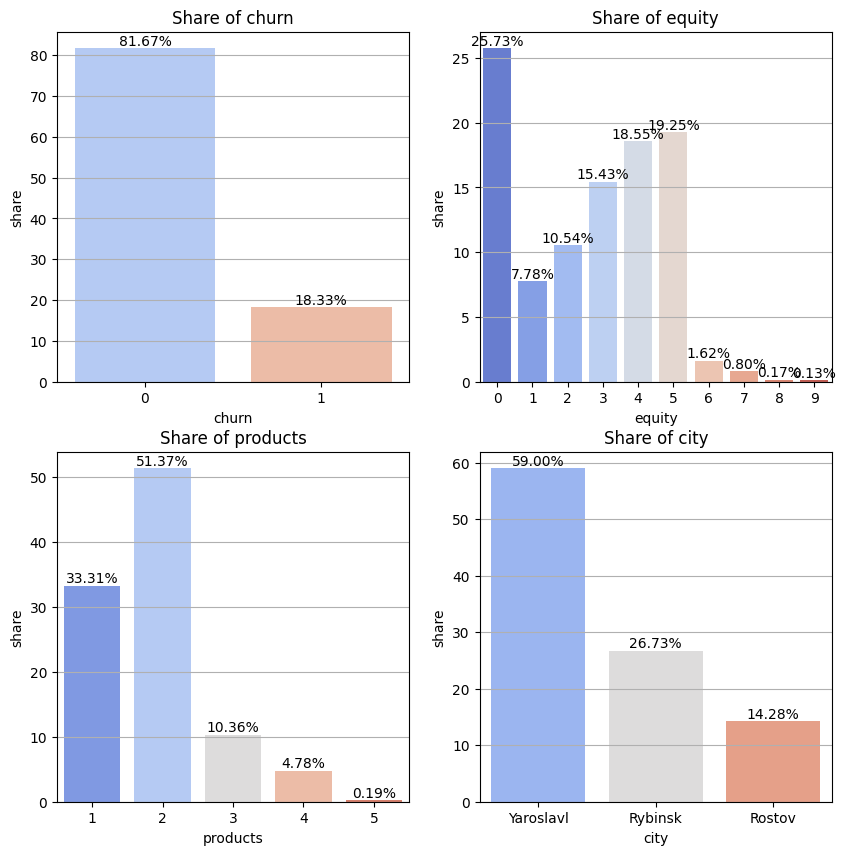

In [20]:
def ax_share_barplot(series):
    bar_data = series.value_counts().reset_index()
    bar_data['share'] = bar_data['count'] / bar_data['count'].sum() * 100
    ax = sns.barplot(data=bar_data, x=series.name, y='share', palette='coolwarm')
    ax.bar_label(ax.containers[0], fmt='%.2f%%')
    ax.set_title(f'Share of {series.name}')
    ax.set_xlabel(series.name)
    return ax

def share_barplots_mult(series, figsize=(10,5)):
    if type(series) == pd.Series:
        plt.figure(figsize=figsize)
        sns.set_style({'axes.grid': True})
        ax_share_barplot(series)
        plt.show()
        
    elif type(series) == list:
        rows = int(np.ceil(len(series) / 2))
        columns = 2
        plt.figure(figsize=(columns * 5, rows * 5))
        sns.set_style({'axes.grid': True})
        axes = []
        plots = []
        for i in range(len(series)):
            axes.append(plt.subplot(rows, columns, i+1))
            plots.append(ax_share_barplot(series[i]))
        
        plt.show()
            
share_barplots_mult([data['churn'], data['equity'], data['products'], data['city']])

More than `25%` of clients have `0` equities and overall more than `97%` of users have `5` or less equities. We can assume that the bank is concentrated on the middle class. 
`~85%` of clients have 1-2 products. Most clients are from Yaroslavl, Rybinsk is on the second place. Rostov is the smallest city in terms of clients number.

### Correlation analysis

In [21]:
# correlations in the data
corr = one_hot_data[['score', 'age', 'equity', 'balance', 'est_salary', 'churn']].corr()
corr

,score,age,equity,balance,est_salary,churn
score,1.000000,-0.012069,0.065689,0.235699,0.164885,0.105935
age,-0.012069,1.000000,0.019717,0.070075,-0.039127,-0.050431
equity,0.065689,0.019717,1.000000,0.164021,-0.171123,0.270326
balance,0.235699,0.070075,0.164021,1.000000,0.339655,0.085343
est_salary,0.164885,-0.039127,-0.171123,0.339655,1.000000,0.001383
churn,0.105935,-0.050431,0.270326,0.085343,0.001383,1.000000


Text(0.5, 1.0, 'Correlation matrix')

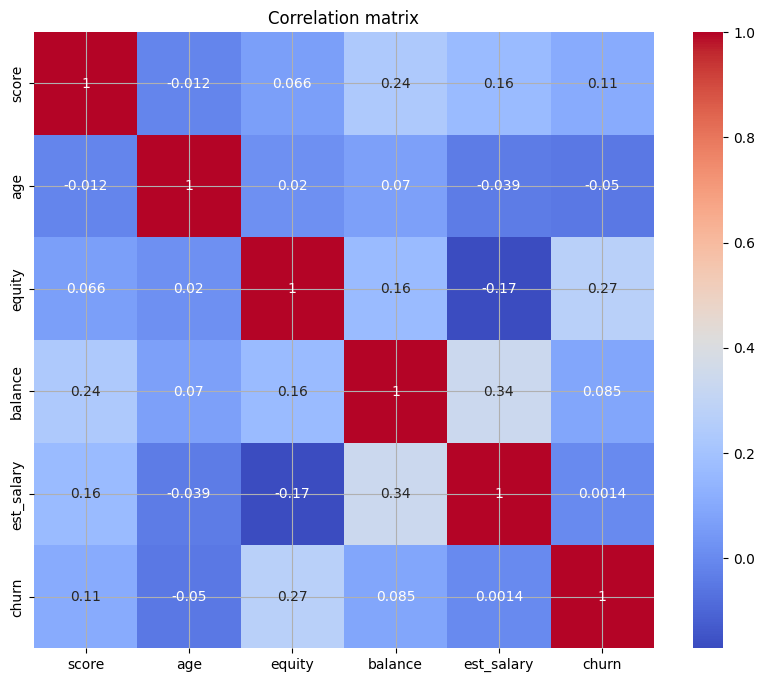

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')

As we can see there are no significant correlations between fields. The only correlation we can see is between `balance` and `estimated_salary` which is `0.34`. It means that the higher the salary the higher the balance. It is logical.

### Distribution of measures

We will use violin plot to see the distribution of `equity`, `balance`, `estimated_salary`, `score` and `age` measures.
Also we will mark the 1.5 IQR to see the outliers using red dashed line

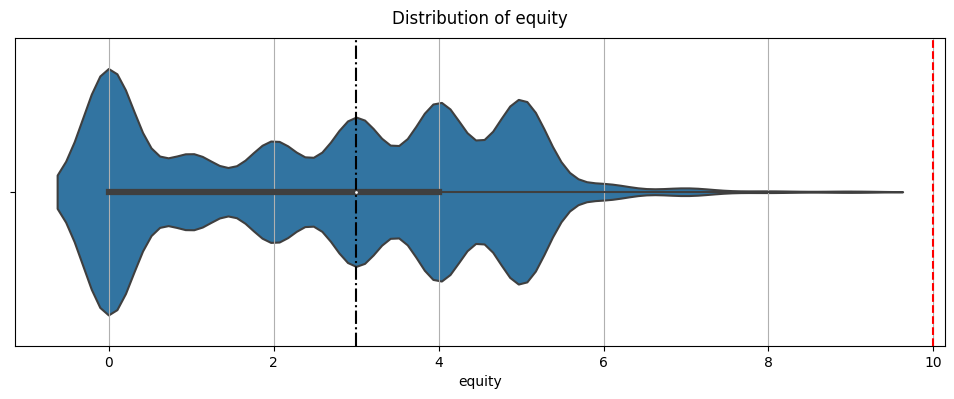

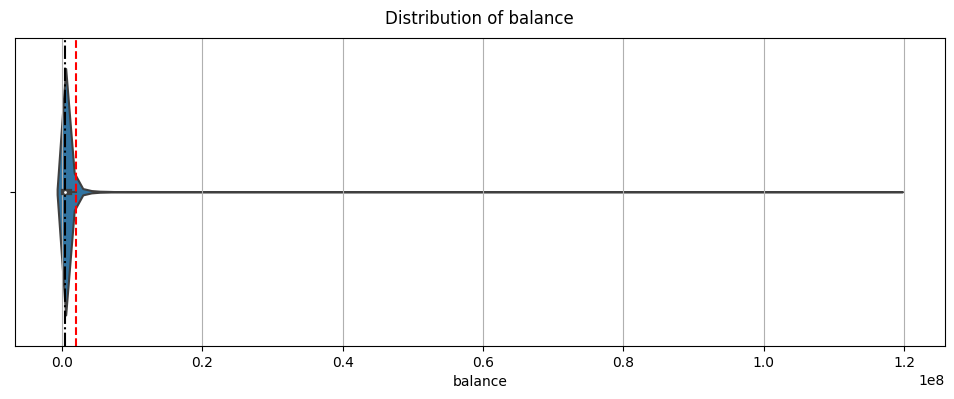

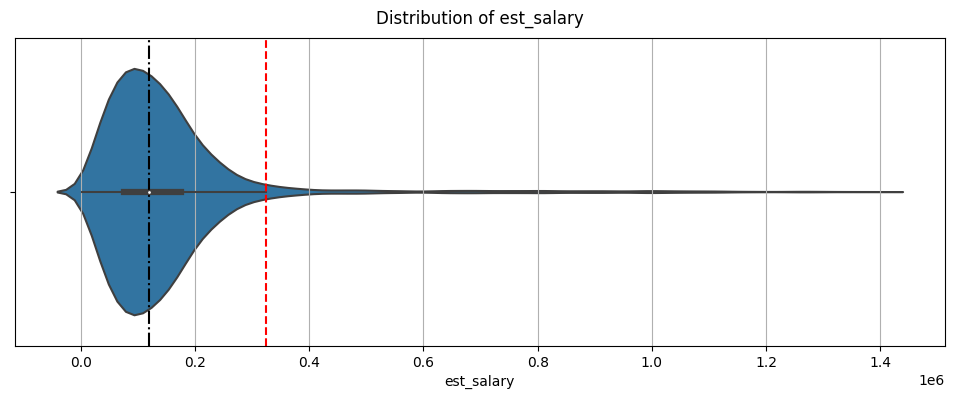

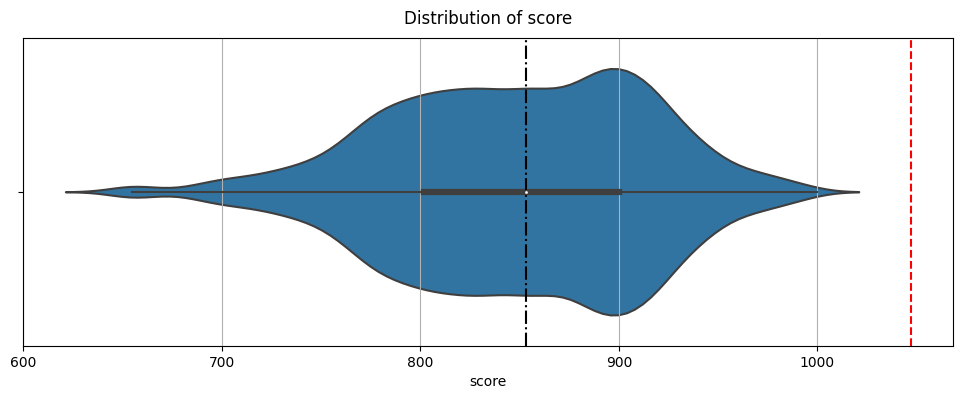

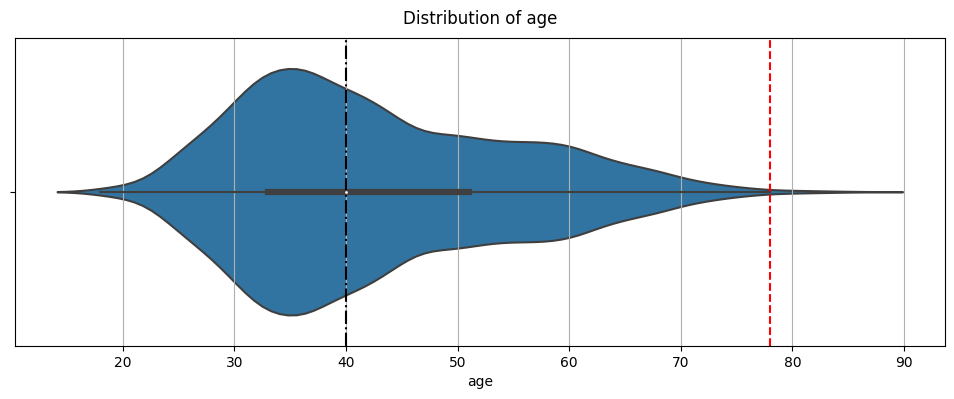

In [23]:
for col in ['equity', 'balance', 'est_salary', 'score', 'age']:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.violinplot(data=one_hot_data, x=col)
    ax.set_title(f'Distribution of {col}', pad=10)
    ax.set_xlabel(col)
    iqr = one_hot_data[col].quantile(0.75) - one_hot_data[col].quantile(0.25)
    ax.axvline(one_hot_data[col].median(), color='black', linestyle='-.')
    ax.axvline(one_hot_data[col].quantile(0.75) + 1.5 * iqr, color='red', linestyle='--')

We can clearly see, that there are a lot of outliers in `balance` and `estimated_salary` columns. For our needs we don't need to remove them, but we should keep in mind that they may affect our analysis.

### Exploration analysis of churned users

We will create a function to plot the percentage of churned users by a given dimension. Also for each dimension all clients will be divided by gender.

In each plot we will mark the baseline churn rate with a purple dashed line. Green bars will show us the percentage of retained users, while red bars will show the percentage of churned users.

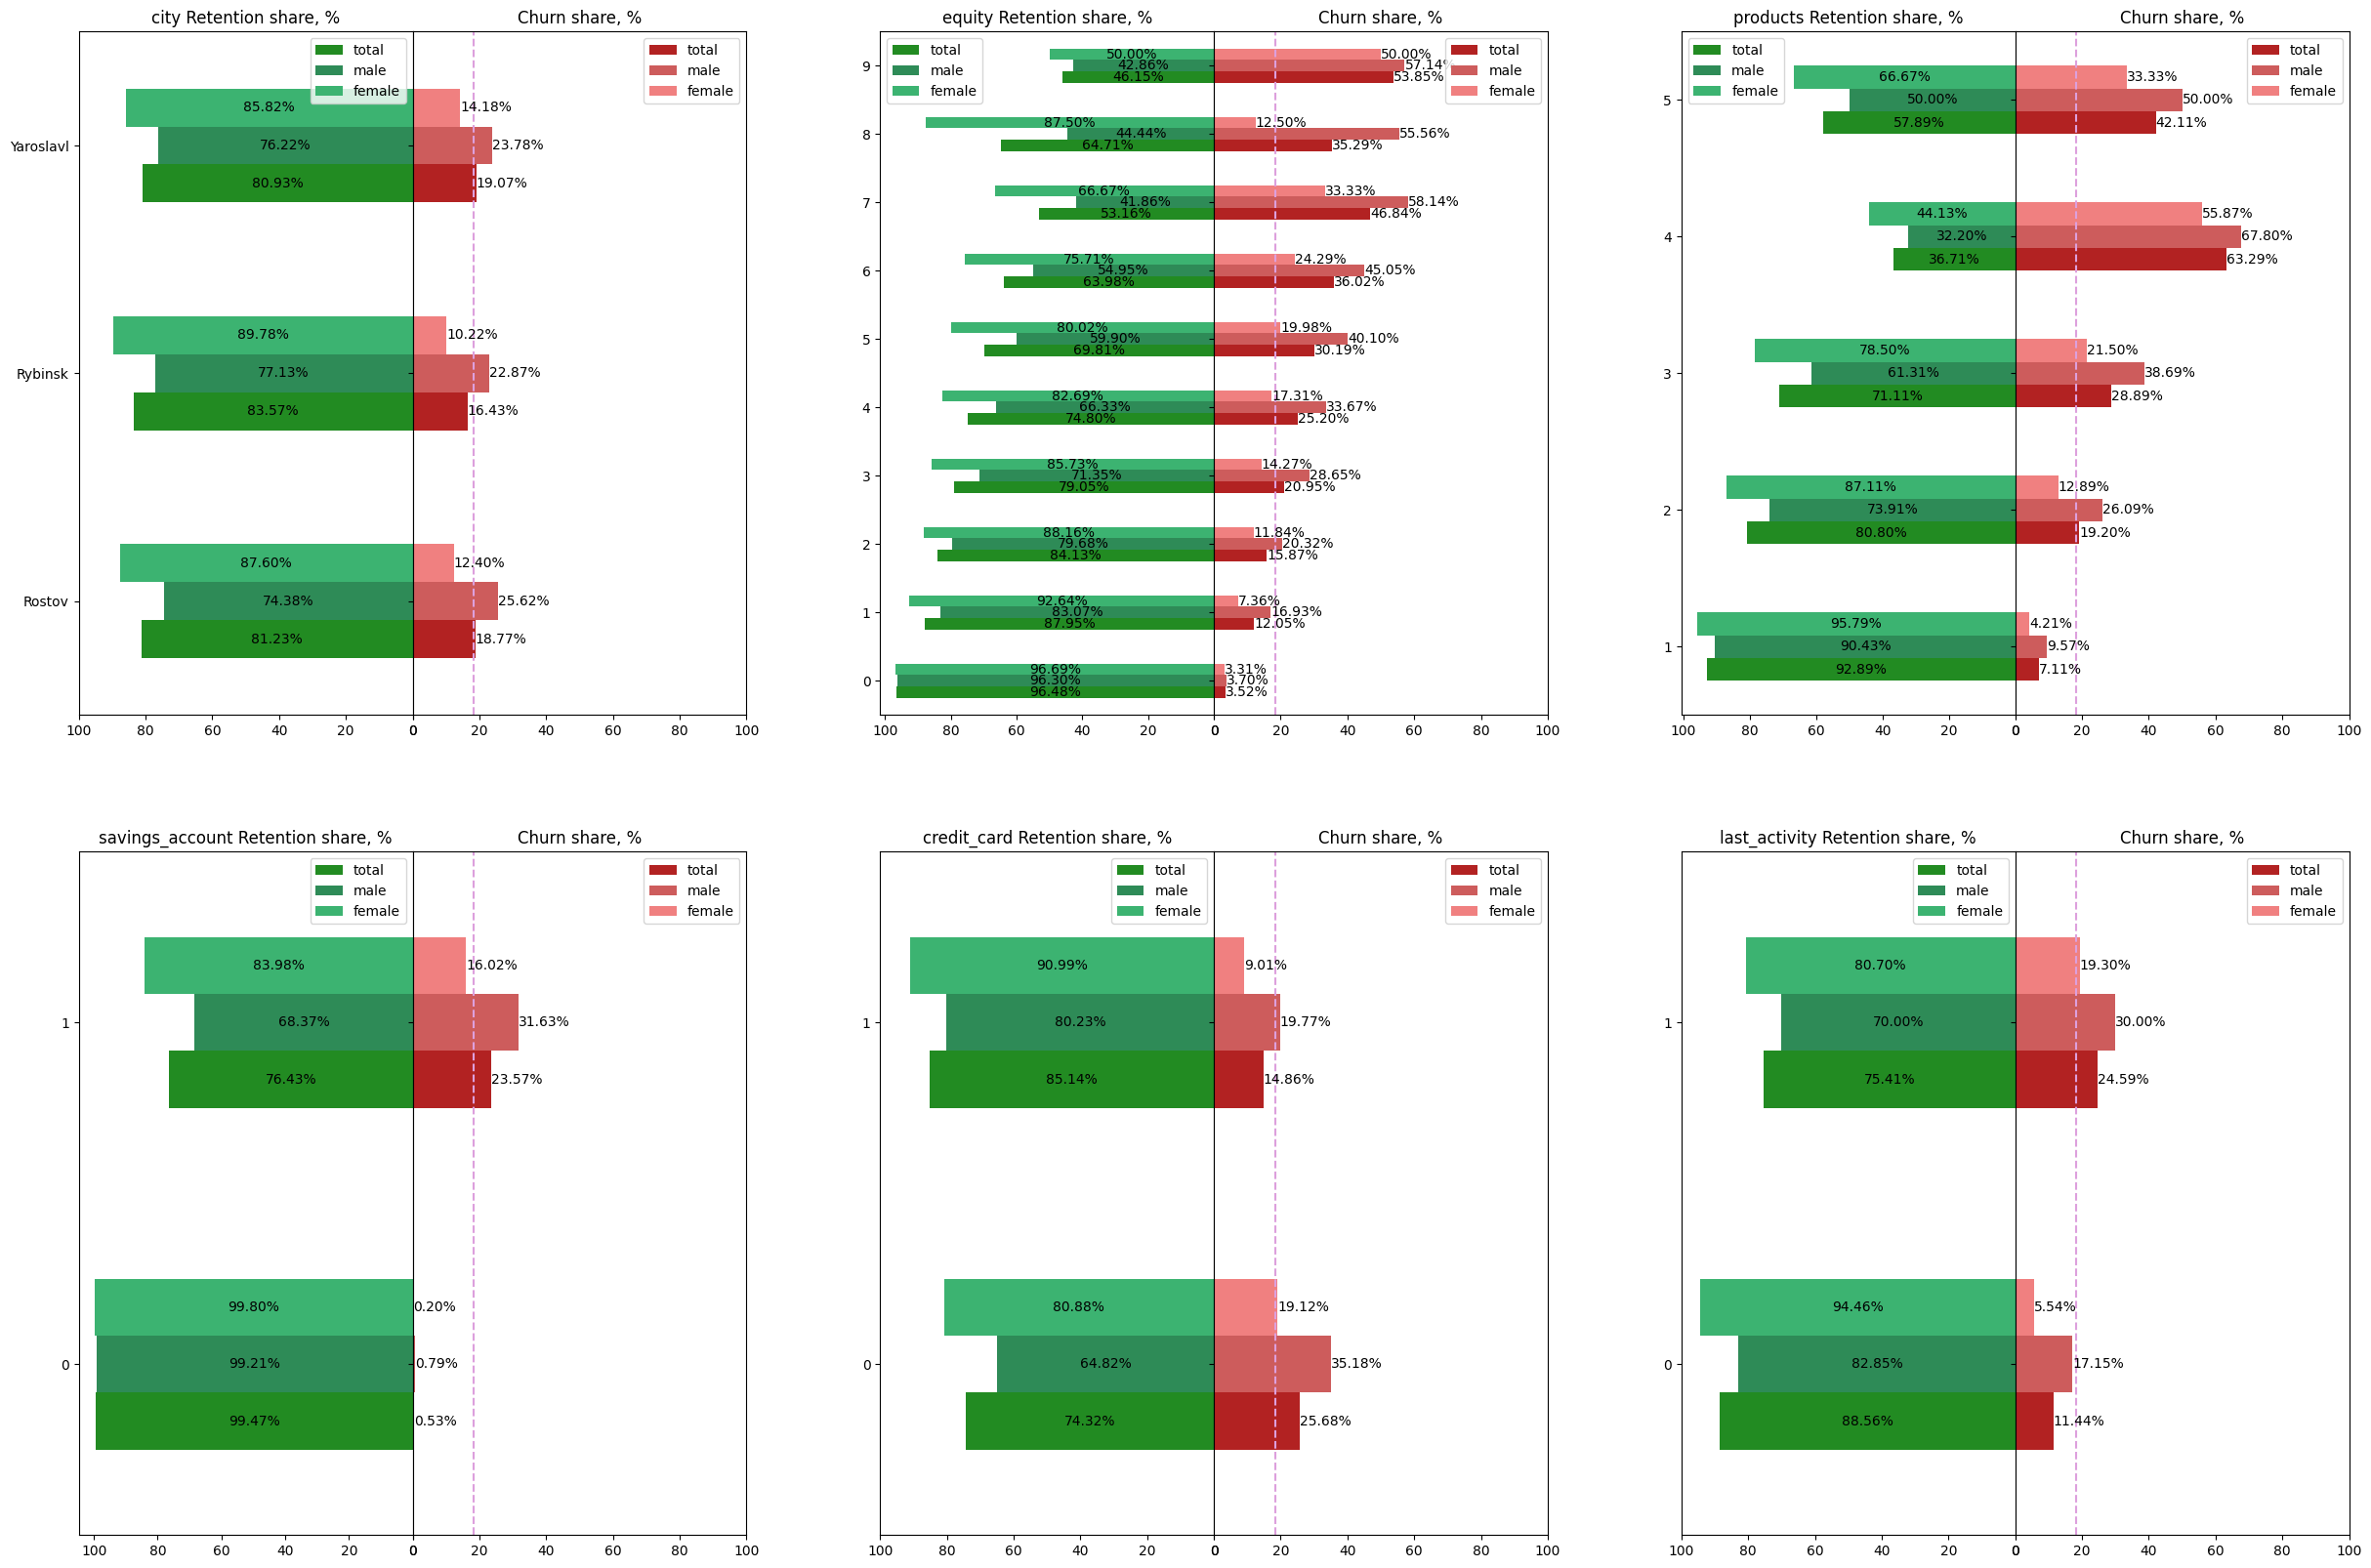

In [24]:
# churn exploration

def churn_share_by_cat(column, outer=gridspec.GridSpec(1, 1)):
    churn_share = one_hot_data.groupby([column, 'gender_male']).agg({'churn': 'sum', 'user_id': 'count'}).reset_index()
    churn_total = one_hot_data.groupby(column).agg({'churn': 'sum', 'user_id': 'count'}).reset_index()
    churn_total['churn_share'] = churn_total['churn'] / churn_total['user_id'] * 100
    churn_total['retention_share'] = 100 - churn_total['churn_share']
    churn_share['churn_share'] = churn_share['churn'] / churn_share['user_id'] * 100
    churn_share['retention_share'] = 100 - churn_share['churn_share']
    df_churn = pd.DataFrame(
        {
            'total': churn_total['churn_share'].to_list(),
            'male': churn_share[churn_share['gender_male'] == 1]['churn_share'].to_list(),
            'female': churn_share[churn_share['gender_male'] == 0]['churn_share'].to_list()
        },
        index=churn_share[column].unique()
    )
    df_retention = pd.DataFrame(
        {
            'total': churn_total['retention_share'].to_list(),
            'male': churn_share[churn_share['gender_male'] == 1]['retention_share'].to_list(),
            'female': churn_share[churn_share['gender_male'] == 0]['retention_share'].to_list()
        },
        index=churn_share[column].unique()
    )
    
    
    title0 = f'{column} Retention share, %'
    title1 = 'Churn share, %'
    
    index = churn_share[column].unique()
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0, hspace=0.1)
    
    ax1 = df_retention.plot.barh(color=['forestgreen', 'seagreen', 'mediumseagreen'], ax=plt.subplot(inner[0]))
    ax1.set_title(title0)
    ax1.set_xticks([0, 20, 40, 60, 80, 100])
    ax1.invert_xaxis()
    ax1.set_yticklabels(index)
    ax1.bar_label(ax1.containers[0], fmt='%.2f%%', label_type='center')
    ax1.bar_label(ax1.containers[1], fmt='%.2f%%', label_type='center')
    ax1.bar_label(ax1.containers[2], fmt='%.2f%%', label_type='center')
    ax1.yaxis.tick_left()
    ax1.grid(False)
    
    ax2 = df_churn.plot.barh(color=['firebrick', 'indianred', 'lightcoral'], ax=plt.subplot(inner[1]))
    ax2.set_title(title1)
    ax2.set_xticks([0, 20, 40, 60, 80, 100])
    ax2.bar_label(ax2.containers[0], fmt='%.2f%%', label_type='edge')
    ax2.bar_label(ax2.containers[1], fmt='%.2f%%', label_type='edge')
    ax2.bar_label(ax2.containers[2], fmt='%.2f%%', label_type='edge')
    ax2.axvline(one_hot_data['churn'].mean() * 100, color='plum', linestyle='--')
    ax2.grid(False)
    
    
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.subplots_adjust(wspace=0.01)

def churn_share_by_cat_mult(cat_list):
    rows = int(np.ceil(len(cat_list) / 3))
    columns = 3
    plt.figure(figsize=(columns * 10, rows * 10))
    for cat in cat_list:
        outer = gridspec.GridSpec(rows, columns, wspace=0.2, hspace=0.2)
        churn_share_by_cat(cat, outer=outer[cat_list.index(cat)])
    
    plt.show()
    
churn_share_by_cat_mult(['city', 'equity', 'products', 'savings_account', 'credit_card', 'last_activity'])

We will binarize dimensions to see the percentage of churned users by each value of the dimension.

age_cat
30-39    3606
40-49    2384
50-59    1597
60+      1195
18-29    1144
Name: count, dtype: int64 

score_cat
850-899    2640
900+       2488
800-849    2425
0-799      2373
Name: count, dtype: int64 

salary_cat
0-99K       3904
100-149K    2558
200K+       1742
150-199K    1722
Name: count, dtype: int64 

balance_cat
1+ KK             4420
0.3 - 0.599 KK    2326
0 - 0.299 KK      1956
0.6 - 0.999 KK    1224
Name: count, dtype: int64 



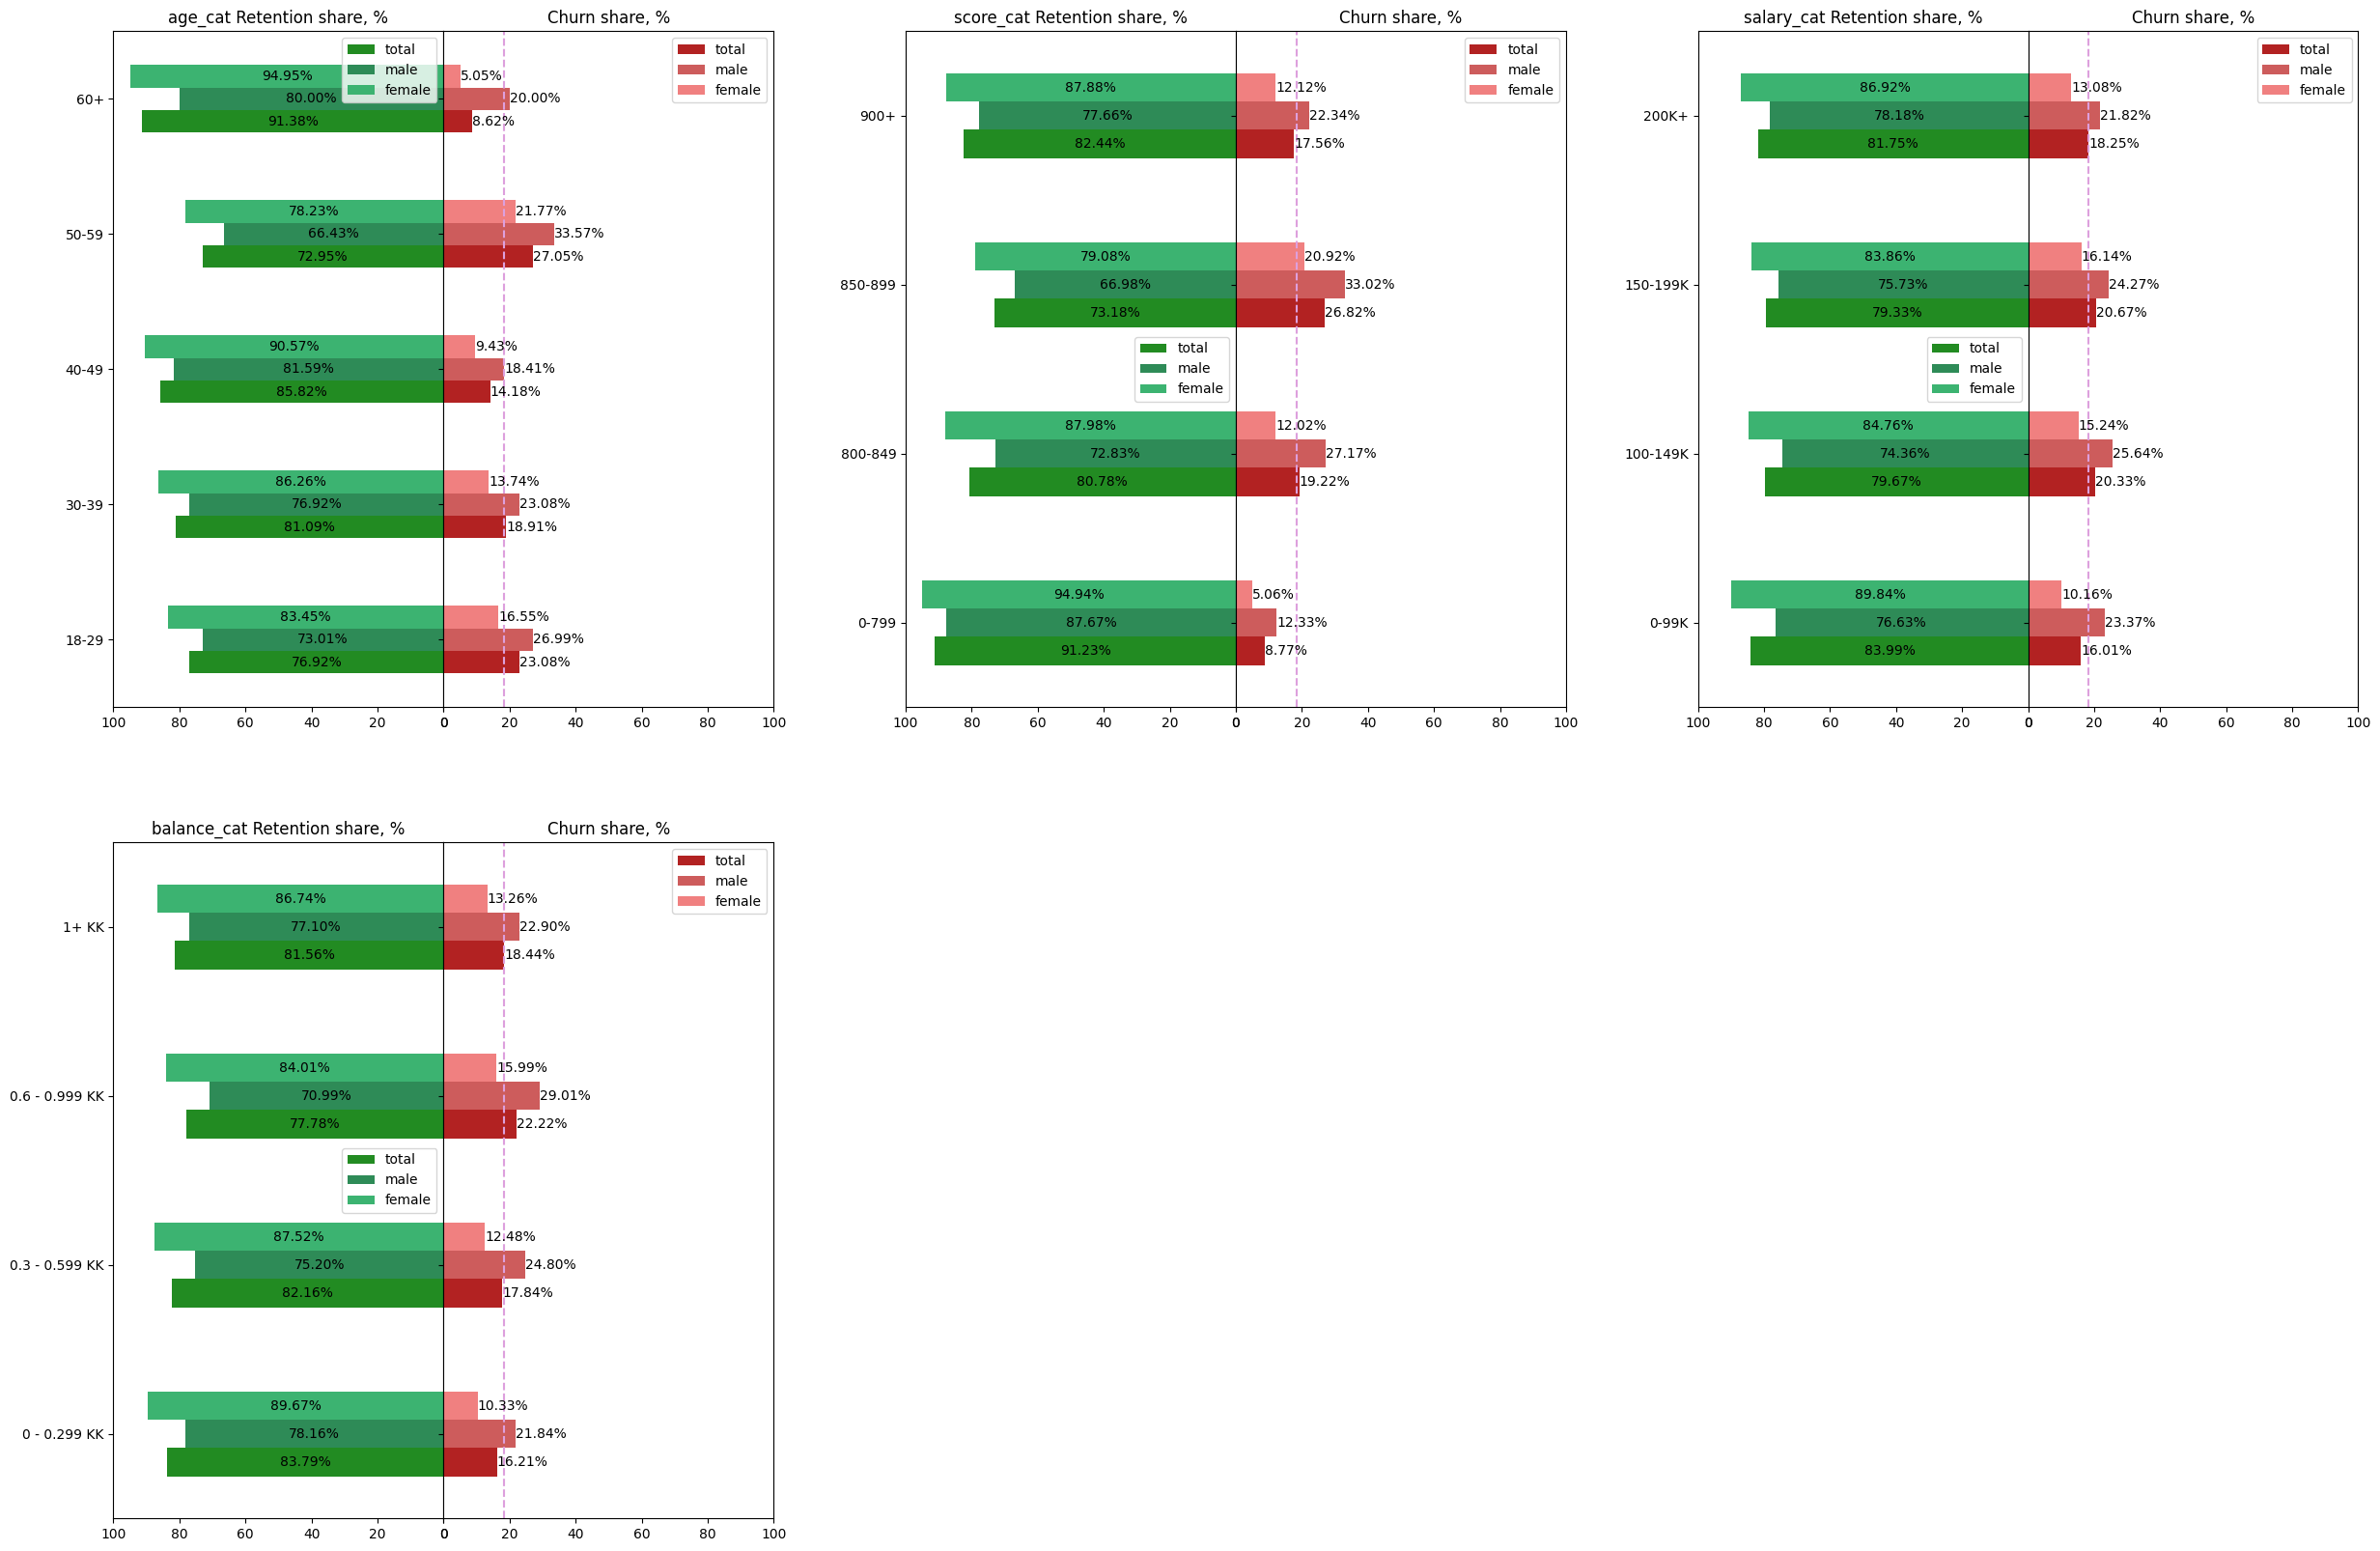

In [25]:
def age_cat(age):
    if age < 30:
        return '18-29'
    elif age < 40:
        return '30-39'
    elif age < 50:
        return '40-49'
    elif age < 60:
        return '50-59'
    else:
        return '60+'

def credit_score_cat(score):
    if score < 800:
        return '0-799'
    elif score < 850:
        return '800-849'
    elif score < 900:
        return '850-899'
    else:
        return '900+'
    
def salary_cat(salary):
    if salary < 100000:
        return '0-99K'
    elif salary < 150000:
        return '100-149K'
    elif salary < 200000:
        return '150-199K'
    else:
        return '200K+'

def balance_cat(balance):
    if balance < 300000:
        return '0 - 0.299 KK'
    elif balance < 600000:
        return '0.3 - 0.599 KK'
    elif balance < 900000:
        return '0.6 - 0.999 KK'
    else:
        return '1+ KK'
    
one_hot_data['age_cat'] = one_hot_data['age'].apply(age_cat)
one_hot_data['score_cat'] = one_hot_data['score'].apply(credit_score_cat)
one_hot_data['salary_cat'] = one_hot_data['est_salary'].apply(salary_cat)
one_hot_data['balance_cat'] = one_hot_data['balance'].apply(balance_cat)
print(one_hot_data['age_cat'].value_counts(), '\n')
print(one_hot_data['score_cat'].value_counts(), '\n')
print(one_hot_data['salary_cat'].value_counts(), '\n')
print(one_hot_data['balance_cat'].value_counts(), '\n')

churn_share_by_cat_mult(['age_cat', 'score_cat', 'salary_cat', 'balance_cat'])

The higher the salary or the balance - the higher churn rate. 
Middle-aged clients are less-likely to churn.
At the same time clients with credit scoring number between 800 and 900 (this range represents the majority of users) are more likely to churn.

Let's build an assymetric violin plots to see the probability density distribution of those columns

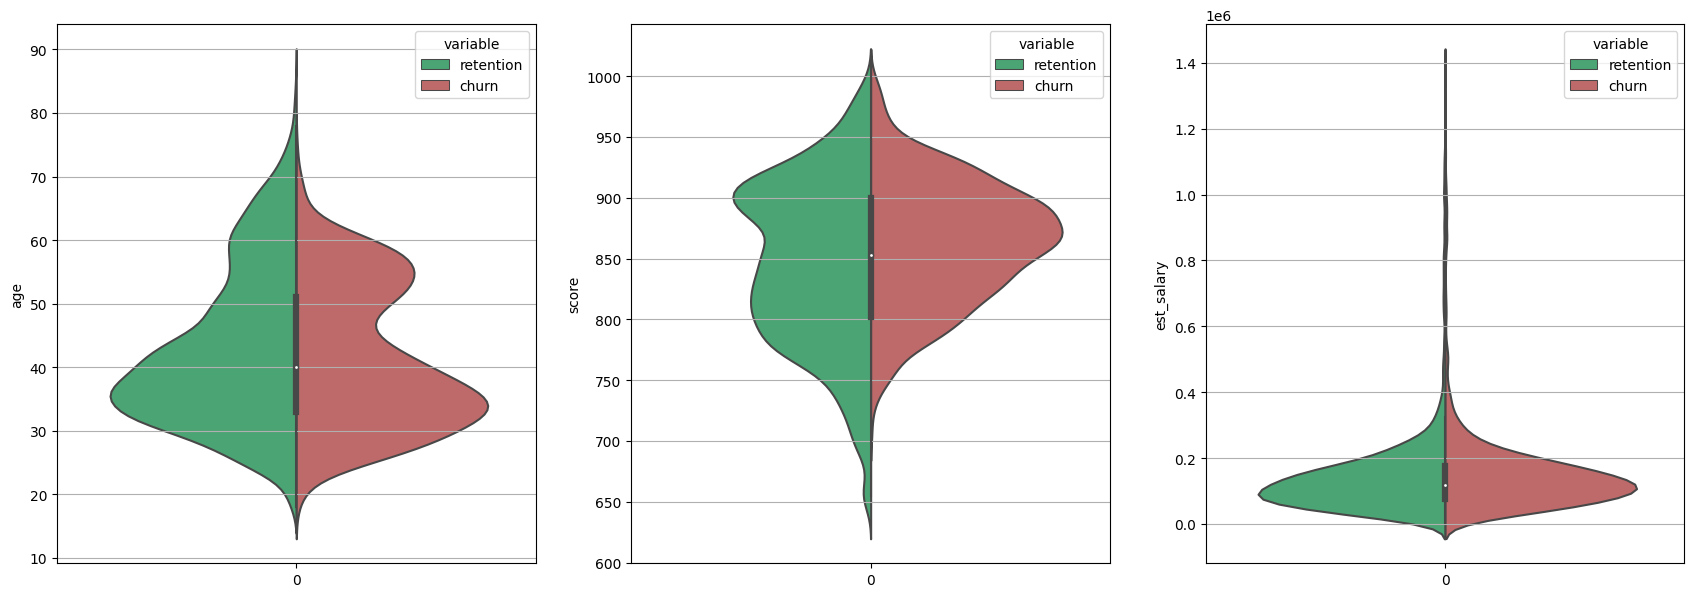

In [26]:
def assymetric_violin_by_cat(column, outer=gridspec.GridSpec(1, 1)):
    # separate columns for churn and retention
    churn = one_hot_data[one_hot_data['churn'] == 1][column]
    retention = one_hot_data[one_hot_data['churn'] == 0][column]
    data = pd.DataFrame({'retention': retention, 'churn': churn})
    data = data.melt()
    data['dummy'] = 0
    plt.subplot(outer)
    sns.violinplot(data=data, x='dummy', y='value', hue='variable', split=True, palette=['mediumseagreen', 'indianred'])
    plt.ylabel(column)
    plt.xlabel('')

def assymetric_violin_by_cat_multiple(cat_list):
    rows = int(np.ceil(len(cat_list) / 3))
    columns = 3
    plt.figure(figsize=(columns * 7, rows * 7))
    for cat in cat_list:
        outer = gridspec.GridSpec(rows, columns, wspace=0.2, hspace=0.2)
        assymetric_violin_by_cat(cat, outer=outer[cat_list.index(cat)])
    
    plt.show()
    
assymetric_violin_by_cat_multiple(['age', 'score', 'est_salary'])

Our previous assumptions were correct. We can continue to segmentation to find clients segments with high and low churn rates.

## Segmentation <a class="anchor" id="segmentation"></a>

### Churn dataframe creation

We will group all clients by churn and calculate values for each column representing the statistically significant numbers. Later on we will compare them to gain more insights on differences between churned and retained users.

In [27]:
churn_grouped = one_hot_data.groupby('churn').agg(
    {
        'age': 'median',
        'score': 'median',
        'equity': pd.Series.mode,
        'balance': 'median',
        'est_salary': 'median',
        'products': pd.Series.mode,
        'credit_card': 'mean',
        'savings_account': 'mean',
        'last_activity': 'mean',
        'city_Rybinsk': 'mean',
        'city_Yaroslavl': 'mean',
        'city_Rostov': 'mean',
        'gender_fem': 'mean',
        'gender_male': 'mean'
    }
).reset_index()

churn_grouped.style.format("{:.3f}")


,churn,age,score,equity,balance,est_salary,products,credit_card,savings_account,last_activity,city_Rybinsk,city_Yaroslavl,city_Rostov,gender_fem,gender_male
0,0.000,40.000,848.000,0.000,475352.420,118247.250,2.000,0.709,0.723,0.483,0.273,0.585,0.142,0.533,0.467
1,1.000,39.000,866.000,5.000,782410.470,125395.220,2.000,0.551,0.993,0.703,0.240,0.614,0.146,0.350,0.650


`equity` and `products`columns were aggregated using `mode` because they are categorical features and their distribution is not normal. For a boolean features we used `mean` aggregation to get the percentage of users with a given value. For numeric measures with a distribution close to normal we used `mean` aggregation. 

Next step is to calculate the difference between churned and retained users for each column. We will use this difference to find segments with high churn rate.

### Differences between groups analysis

In [28]:

churn_difference = pd.concat([
    churn_grouped,
    churn_grouped.pct_change().rename(index={0: 'pct_change'})
]).reset_index().drop(2).reset_index(drop=True)
churn_difference.loc[2] = churn_difference.loc[2] * 100
churn_difference.drop('index', axis=1, inplace=True)
churn_difference.style.format("{:.3f}")

,churn,age,score,equity,balance,est_salary,products,credit_card,savings_account,last_activity,city_Rybinsk,city_Yaroslavl,city_Rostov,gender_fem,gender_male
0,0.000,40.000,848.000,0.000,475352.420,118247.250,2.000,0.709,0.723,0.483,0.273,0.585,0.142,0.533,0.467
1,1.000,39.000,866.000,5.000,782410.470,125395.220,2.000,0.551,0.993,0.703,0.240,0.614,0.146,0.350,0.650
2,inf,-2.500,2.123,inf,64.596,6.045,0.000,-22.203,37.432,45.339,-12.351,5.049,2.999,-34.355,39.151


In [29]:
# top characteristics of churned users
top_characteristics = churn_difference.loc[2].sort_values(ascending=False, key=abs)
top_characteristics

churn                    inf
equity                   inf
balance            64.595874
last_activity      45.339300
gender_male        39.151411
savings_account    37.432046
gender_fem        -34.354955
credit_card       -22.203012
city_Rybinsk      -12.350737
est_salary          6.044936
city_Yaroslavl      5.049488
city_Rostov         2.999185
age                -2.500000
score               2.122642
products            0.000000
Name: 2, dtype: float64

Here are the most significant differences between churned and retained users:
- `equity`- churned users have more equities than retained users (`mode = 5` vs `mode = 0`)
- `balance` - churned users have more money on their accounts than retained users (`change of mean ~ 64.6%`)
- `last_activity` - churned users are more active than retained users (`change of mean ~ 45.3%`)
- `gender` - males are more likely to churn
- `saving_account` - clients with savings account are more likely to churn
- `credit_card` - clients with credit card are less likely to churn


### Segmentation

Let's define segments based on our previous findings:

In [30]:
est_salary_q = one_hot_data['est_salary'].quantile(0.75)

# Segmentation:
print('Total records: ', one_hot_data.shape[0])
print(f'Total churn share: {(one_hot_data["churn"].mean()):.2%}')

print(50*'-', '\nLoyal segment 1: females with credit card, not active, and not wealthy')
# Loyal segment 1 - females with credit card and not active users
loyal_seg1 = one_hot_data.query(
    'gender_fem == 1 & credit_card == 1 & (equity < 3 | balance < 600000 | est_salary < @est_salary_q) & last_activity == 0'
)
print('Loyal segment 1 size: ', loyal_seg1.shape[0])
print(f'Loyal segment 1 churn share: {(loyal_seg1["churn"].mean()):.2%}')

print('\nSame segment without activity filter:')
loyal_seg1_no_activity = one_hot_data.query(
    'gender_fem == 1 & credit_card == 1 & (equity < 3 | balance < 600000 | est_salary < @est_salary_q)'
)
print('Loyal segment 1 (no activity filter) size: ', loyal_seg1_no_activity.shape[0])
print(f'Loyal segment 1 (no activity filter) churn share: {(loyal_seg1_no_activity["churn"].mean()):.2%}')

print(50*'-', '\nLoyal segment 2: clients without savings account, not wealthy')
loyal_seg2 = one_hot_data.query(
    'savings_account == 0 & (equity < 3 | balance < 600000 | est_salary < @est_salary_q)'
)
print('Loyal segment 2 size: ', loyal_seg2.shape[0])
print(f'Loyal segment 2 churn share: {(loyal_seg2["churn"].mean()):.2%}')

print(50*'-', '\nChurn segment 1: males without credit card, active, and wealthy')
churn_seg1 = one_hot_data.query(
    'gender_male == 1 & credit_card == 0 & (equity >= 3 | balance >= 600000 | est_salary >= @est_salary_q) & last_activity == 1'
)
print('Churn segment 1 size: ', churn_seg1.shape[0])
print(f'Churn segment 1 churn share: {(churn_seg1["churn"].mean()):.2%}')

print('\nSame segment without activity filter:')
churn_seg1_no_activity = one_hot_data.query(
    'gender_male == 1 & credit_card == 0 & (equity >= 3 | balance >= 600000 | est_salary >= @est_salary_q)'
)
print('Churn segment 1 (no activity filter) size: ', churn_seg1_no_activity.shape[0])
print(f'Churn segment 1 (no activity filter) churn share: {(churn_seg1_no_activity["churn"].mean()):.2%}')

print(50*'-', '\nChurn segment 2: clients with savings account and without credit card, wealthy')
churn_seg2 = one_hot_data.query(
    'savings_account == 1 & credit_card == 0 & (equity >= 3 | balance >= 600000 | est_salary >= @est_salary_q)'
)
print('Churn segment 2 size: ', churn_seg2.shape[0])
print(f'Churn segment 2 churn share: {(churn_seg2["churn"].mean()):.2%}')

Total records:  9926
Total churn share: 18.33%
-------------------------------------------------- 
Loyal segment 1: females with credit card, not active, and not wealthy
Loyal segment 1 size:  1390
Loyal segment 1 churn share: 4.96%

Same segment without activity filter:
Loyal segment 1 (no activity filter) size:  2904
Loyal segment 1 (no activity filter) churn share: 8.06%
-------------------------------------------------- 
Loyal segment 2: clients without savings account, not wealthy
Loyal segment 2 size:  2259
Loyal segment 2 churn share: 0.53%
-------------------------------------------------- 
Churn segment 1: males without credit card, active, and wealthy
Churn segment 1 size:  591
Churn segment 1 churn share: 49.58%

Same segment without activity filter:
Churn segment 1 (no activity filter) size:  1063
Churn segment 1 (no activity filter) churn share: 40.64%
-------------------------------------------------- 
Churn segment 2: clients with savings account and without credit card,

### Intermediary conclusions

We've defined `4` segments, `2` of them have _low churn rate_ and `2` have _hign churn rate_. We are also defined `wealthy` clients as clients which have `equity` score of `3` or more or `balance` of `600,000` or more or `estimated_salary` higher than 75% of all clients.

#### First _loyal_ segment, more strict filters
**Filters:**
- Females
- With credit card
- Not active _(optional)_
- Not wealthy

**Churn rate:** `~5%` of `1390` clients in segment. If we remove the `not active` filter, the churn rate will be `~8%`, but we will significantly increase segment size, up to `2904`.

#### Second _loyal_ segment, less strict filters
**Filters:**
- No savings account
- Not wealthy

**Churn rate:** `~0.53%` of `2259` clients in segment.

#### First _disloyal_ segment, more strict filters
**Filters:**
- Males
- No credit card
- Active _(optional)_
- Wealthy

**Churn rate:** `~49.58%` of `591` clients in segment. If we remove the `active` filter, the churn rate will be `~40.68%`, but we will significantly increase segment size, up to `1063`.

#### Second _disloyal_ segment, less strict filters
**Filters:**
- Savings account
- Without credit card
- Wealthy

**Churn rate:** `~32.39%` of `2294` clients in segment.

## Hypothesis testing <a class="anchor" id="hypothesis-testing"></a>

In previous steps we'd found that wealth is a significant factor for churn. Let's test this hypothesis. 

Since we have a lot of outliers in `equity`, `balance` and `estimated_salary` columns, we will use `Mann-Whitney U test` to test the hypothesis.

Each column will be tested separately and twice. Firstly we will test the two-sided hypothesis, and then we will perform one-sided test to see if the difference is positive or negative. 

We will use `0.05` as a significance level.

In [31]:
# hypotheses testing:
alpha = 0.5
for col in ['equity', 'balance', 'est_salary']:
    churn_group = one_hot_data[one_hot_data['churn'] == 1][col]
    retention_group = one_hot_data[one_hot_data['churn'] == 0][col]
    utest_diff = stats.mannwhitneyu(churn_group, retention_group, alternative='two-sided', nan_policy='omit')
    utest_greater = stats.mannwhitneyu(churn_group, retention_group, alternative='greater', nan_policy='omit')
    if utest_diff.pvalue > alpha:
        print(f'For {col} there is no difference between churn and retention groups; P-value = {utest_diff.pvalue}')
    else:
        print(f'For {col} there is a statistically significant difference between churn and retention groups; P-value = {utest_diff.pvalue}')
        
    if utest_greater.pvalue > alpha:
        print(f'Average {col} in the churn group is not greater than in the retention group; P-value = {utest_greater.pvalue}')
    else:
        print(f'Average {col} in the churn group is greater than in the retention group; P-value = {utest_greater.pvalue}')
    
    print()

For equity there is a statistically significant difference between churn and retention groups; P-value = 7.188830962860143e-157
Average equity in the churn group is greater than in the retention group; P-value = 3.5944154814300716e-157

For balance there is a statistically significant difference between churn and retention groups; P-value = 3.100134518824303e-70
Average balance in the churn group is greater than in the retention group; P-value = 1.5500672594121515e-70

For est_salary there is a statistically significant difference between churn and retention groups; P-value = 0.00022703693954923942
Average est_salary in the churn group is greater than in the retention group; P-value = 0.00011351846977461971



All the tests show that the difference in wealth between churned and retained users is statistically significant. The difference is positive, which means that the more wealthy the client is, the more likely he is to churn as we have suggested before.

## Conclusion <a class="anchor" id="conclusion"></a>

#### Overview

Bank is clearly focused on the middle class. That may be the reason why some terms of service are not attractive for wealthy clients, that results in a high churn rate because wealthy clients account for a significant part of the bank's clients. 
Analysis also shows that offering credit cards to clients may reduce churn rate. That makes sense since credit card is a good way to increase financial flexibility while using bank services, it helps to improve bank-client relationships.
Also the difference between males and females in churn rate is high. That may signalize that men are more likely to compare different products and are more likely to switch to another bank if they find a better offer. 
It also seems like bank isn't promoting products. Most clients have 2 products or even 1. And clients with 3 or more products are more likely to churn. That may be because they are not satisfied with overall experience with the bank.
Saving account terms are also should be reviewed. Clients with savings accounts are more likely to churn, both wealthy and not wealthy.
Elder people (`59+`) are less likely to churn. That may be because they are more conservative and don't want to change their bank.

#### Typical client portraits

**Loyal client:**
- **Gender:** Female
- **Age:** 30 - 49
- **Estimated Salary:** 75,000 - 175,000
- **Equity:** 0 - 2
- **Balance:** 0 - 600,000
- **Products:** 1 - 2, one of them is credit card
- **Creit Score:** approximately 820

**Disloyal client:**
- **Gender:** Male
- **Age:** below 40, most likely 30-35
- **Estimated Salary:** 100,000 - 200,000
- **Equity:** 3 - 5
- **Balance:** 600,000 - 1,000,000
- **Products:** 1 - 2, no credit card
- **Creit Score:** approximately 870

## Recommendations <a class="anchor" id="recommendations"></a>

1. Review terms of service for wealthy clients. Make sure that they are attractive enough. Maybe create personalized offers.
2. Promote credit cards to clients. Especially the ones with higher credit/equity scoring or wealthy ones.
3. Review saving account terms. Make them more flexible, create more options for different segments. Compare with competitors offers.
4. Promote products to clients. Make sure that clients know about all products that bank offers. Make usage of multiple products more attractive, beneficial and convenient. 
5. It may be usefull to create (or reconsider terms if exists) a loyalty program for clients. This may help to increase retention rate while promoting products and services. This loyalty programm should be personalized for each client segment, including wealthy clients.